In [1]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
# tf.disable_eager_execution()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


##### Set the path of code folder containing GANSim codes

In [3]:
new_path = r'/home/users/suihong/11-GenerativeGeomodelling_GANs_MPS_Comparison/GANSimForAllConditioning_20250718/2_GANSimTraining/' 
sys.path.append(new_path)

### 1. Load test dataset

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [4]:
data_dir_test = '/scratch/users/suihong/Mud_drape_Channels/PreparedDataset/'

In [5]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

test_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']

# loaded labels (global features) have been normalized into -1 to 1
# Denormalize the global features back into its orginal range 
pb_cf_ratio = labels_test[:, 0] # pb_cf_ratio has been normalized
pb_cf_ratio = (pb_cf_ratio / 2 + 0.5) * (2 - 0.2) + 0.2
fp_prop = labels_test[:, 1] # fp_prop has been normalized
fp_prop = (fp_prop / 2 + 0.5) * (0.82 - 0.5) + 0.5

print(facies_test.shape)
print(pb_cf_ratio.shape)
print(fp_prop.shape)
print(probimgs_test.shape)
print(wellfaciesimgs_test.shape)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
(1000, 1, 64, 64)
(1000,)
(1000,)
(1000, 3, 64, 64)
(1000, 1, 64, 64)


In [6]:
# In the test and training facies models, the facies codes are 0, 1, 3, and 4, corresponding to the four facies types.
# The generator produces facies indicator models, which are then converted into facies models using an argmax function.
# As a result, the generated facies models have codes 0, 1, 2, and 3.
# To facilitate comparison between the test and generated facies models, the test facies codes are also remapped to 0, 1, 2, and 3.

facies_test_newcode = np.where(facies_test>2, facies_test-1, facies_test)

In [7]:
# Correspondingly, in the training/test dataset, the well facies data have the codes of 0 (non-well), 1 (floodplain facies), 2 (mud drape)
# 4 (abandoned channels), and 5 (sandy lateral accretion). Now, they are also converted into 0, 1, 2, 3, 4.

wellfaciesimgs_test_newcode = np.where(wellfaciesimgs_test>3, wellfaciesimgs_test-1, wellfaciesimgs_test)

### 2. Preparing dataset of a test case

In [8]:
# select a test case having the global features of 0.74 for floodplain proportion and 1.14 for point bar-to-channel fill proportion.
# Such global features are consistent with a constructed large TI, which will be used for MPS simulation.

d_ = (fp_prop - 0.74)**2 + (pb_cf_ratio - 1.14)**2
test_num = np.argsort(d_)[0]

print(test_num)
print(d_[test_num])
print(fp_prop[test_num])
print(pb_cf_ratio[test_num])

82
6.094283e-05
0.74658203
1.1358024


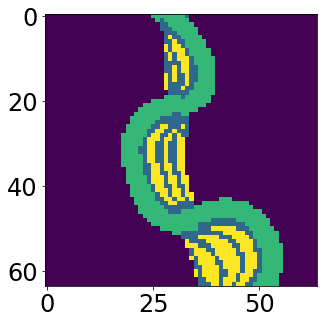

In [9]:
# Ground truth test facies model

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5, forward=True)

ax.imshow(facies_test_newcode[test_num,0,:,:])

#plt.savefig(GANSim_dir + "Case1_ground_truth.png", dpi=200) 


In [10]:
# Generate more complex random well facies points for conditioning

well_points_test_illu = np.zeros((1, 1, 64, 64), dtype = np.int8)
for i in range(well_points_test_illu.shape[0]):
    well_points_num = 8  # Random choose the expected total number of well points
    xs = np.random.RandomState(12).choice(well_points_test_illu.shape[2], well_points_num)
    ys = np.random.RandomState(371).choice(well_points_test_illu.shape[3], well_points_num)
    well_points_test_illu[i, 0, xs, ys] = 1
    
well_facies_test_illu = facies_test[test_num:test_num+1] * well_points_test_illu
well_facies_test_illu = well_facies_test_illu + well_points_test_illu
print(well_facies_test_illu.shape)

wellfaciesimgs_test_loc_illu = np.where(well_facies_test_illu>0, 1, 0)
wellfaciesimgs_test_fc_illu = (well_facies_test_illu - 1) * wellfaciesimgs_test_loc_illu
wellfaciesimgs_test_G_illu = np.concatenate([wellfaciesimgs_test_loc_illu, wellfaciesimgs_test_fc_illu], axis = 1)
print(wellfaciesimgs_test_G_illu.shape)

def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,2,2], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el
well_facies_test_illu_newcode = np.where(well_facies_test_illu>2, well_facies_test_illu - 1, well_facies_test_illu)
wellfacies_onechannel_illu = enlarge(well_facies_test_illu_newcode)
wellfacies_onechannel_mask_illu = np.ma.masked_where(wellfacies_onechannel_illu == 0, wellfacies_onechannel_illu)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

(1, 1, 64, 64)
(1, 2, 64, 64)


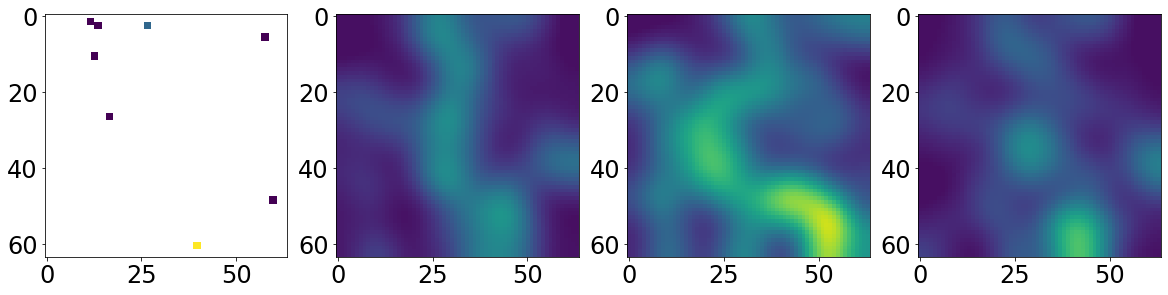

In [11]:
# Visualize conditioning well facies data and probability maps for the selected test facies models

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(20, 5, forward=True)

ax[0].imshow(wellfacies_onechannel_mask_illu[0, 0], cmap=cmap_well, vmin = 1, vmax = 4)
ax[1].imshow(probimgs_test[test_num, 0].astype(np.float32), vmin = 0, vmax = 0.5)
ax[2].imshow(probimgs_test[test_num, 1].astype(np.float32), vmin = 0, vmax = 0.5)
ax[3].imshow(probimgs_test[test_num, 2].astype(np.float32), vmin = 0, vmax = 0.5)

#plt.savefig(GANSim_dir + "Case1_well_prob.png", dpi=200) 

### 3. Simulation with Petrel-embedded SNESIM MPS algorithm

*Save conditioning data for SNESIM simulation in Petrel*

In [12]:
well_cond_case1 = wellfaciesimgs_test_G_illu[0, 0] + wellfaciesimgs_test_G_illu[0, 1]
well_cond_case1 = np.where(well_cond_case1 < 1, -99, well_cond_case1 - 1)

# Concatenate the arrays along axis 1
condition_data_case1 = np.concatenate((well_cond_case1.reshape(-1, 1), 
                                       probimgs_test[test_num, 0].reshape(-1, 1), 
                                       probimgs_test[test_num, 1].reshape(-1, 1), 
                                       probimgs_test[test_num, 2].reshape(-1, 1)), axis=1)

# Export the data to a CSV file 
#np.savetxt('/scratch/users/suihong/GenerativeGeomodelling_MPS/PointBar/conditioning_data_case1', condition_data_case1, delimiter=' ', fmt=['%d', '%.6f', '%.6f', '%.6f'])


*After simulation with Petrel, load the simulated facies models to visualize and compare with GANSim results*

In [13]:
# path of SNESMI results
Filepath = '/scratch/users/suihong/GenerativeGeomodelling_MPS/PointBar/pointbar_cond_faciesmodels_case1'

allele=[]  # store all elements of the file. including 64*64 lists, and each list includes code for all realizations
with open (Filepath) as fl:
    for line in fl:
        eles = line.strip().split(' ')
       
        if len(eles)>=5:            
            allele.append(eles)

mps_results=np.array(allele, dtype=np.float32).reshape(64, 64, -1).astype(np.int32)  # all imges (realizations), of shape (64,64, rlz_no)
mps_results = mps_results[::-1,:,:]

def swap_code_1_3(orig_facies):
    new_facies = np.where((orig_facies == 1) | (orig_facies == 3), 4 - orig_facies, orig_facies)
    return new_facies
mps_results = swap_code_1_3(mps_results)
print(mps_results.shape)

(64, 64, 100)


In [14]:
## check well conditioning effect:
wellfaciesimgs_test_G_illu_fc = wellfaciesimgs_test_G_illu[0, 1]
wellfaciesimgs_test_G_illu_fc_cor = np.where(wellfaciesimgs_test_G_illu_fc > 2, wellfaciesimgs_test_G_illu_fc - 1, wellfaciesimgs_test_G_illu_fc)
well_cond_check = np.sum(((mps_results - wellfaciesimgs_test_G_illu_fc_cor[:, :, np.newaxis]) 
                        * wellfaciesimgs_test_G_illu[0, 0][:, :, np.newaxis])**2)

print(well_cond_check)
# 0 means 100% reproduction accuracy

0


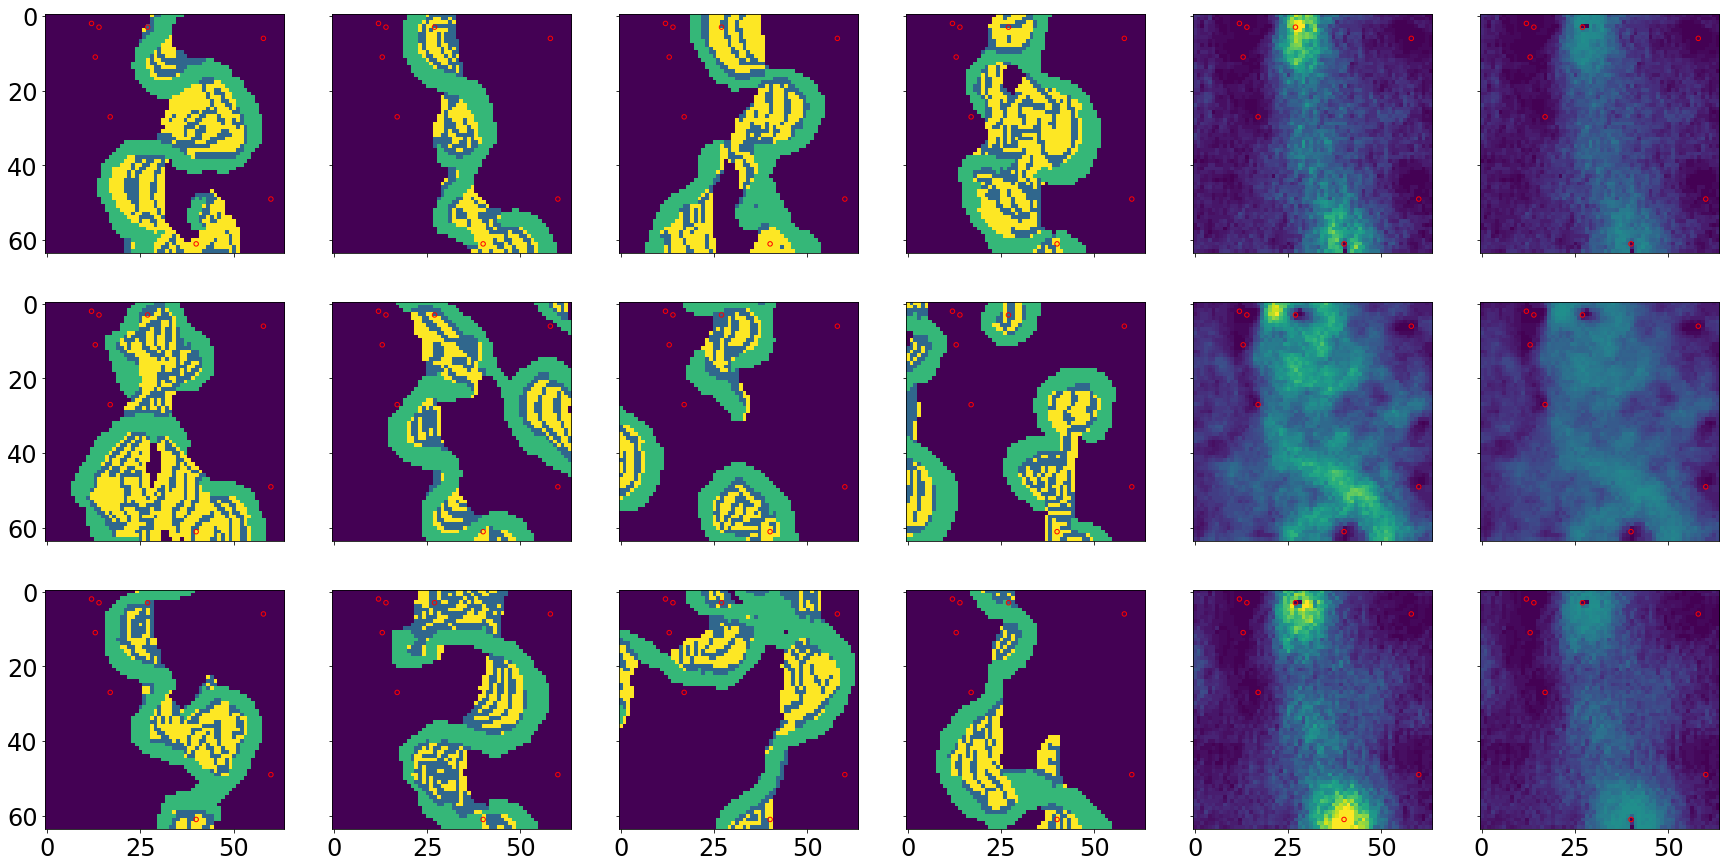

In [15]:
# Several realizations and mean and std

snesim_freq_md = np.mean(np.where(mps_results == 1, 1, 0), axis = 2)
snesim_var_md = np.var(np.where(mps_results == 1, 1, 0), axis = 2)
snesim_freq_cf = np.mean(np.where(mps_results == 2, 1, 0), axis = 2)
snesim_var_cf = np.var(np.where(mps_results == 2, 1, 0), axis = 2)
snesim_freq_la = np.mean(np.where(mps_results == 3, 1, 0), axis = 2)
snesim_var_la = np.var(np.where(mps_results == 3, 1, 0), axis = 2)

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 6, sharex='col', sharey='row')
fig.set_size_inches(30, 15, forward=True)
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(mps_results[:, :, i*5+j+10])
ax[0, 4].imshow(snesim_freq_md, vmin = 0, vmax = 0.5) 
ax[0, 5].imshow(snesim_var_md, vmin = 0, vmax = 0.5) 
ax[1, 4].imshow(snesim_freq_cf, vmin = 0, vmax = 0.5) 
ax[1, 5].imshow(snesim_var_cf, vmin = 0, vmax = 0.5) 
ax[2, 4].imshow(snesim_freq_la, vmin = 0, vmax = 0.5) 
ax[2, 5].imshow(snesim_var_la, vmin = 0, vmax = 0.5) 

index_x=np.argwhere(wellfaciesimgs_test_G_illu[0, 0]>0)[:, 1]
index_y=np.argwhere(wellfaciesimgs_test_G_illu[0, 0]>0)[:, 0]
for i in range(3):
    for j in range(6):
        ax[i, j].scatter(index_x, index_y, s=20, marker='o', facecolor='none', edgecolor='red')

#plt.savefig('/scratch/users/suihong/GenerativeGeomodelling_MPS/PointBar/Cond_realizations_freq_case1', dpi=200) 

### 4. Train and simulation with trained conditional generator

#### (1) Load trained generator

In [16]:
GANSim_dir = '/scratch/users/suihong/Mud_drape_Channels/TrainedModels/062-prog_2gpu-CondWell_w100-CondProb/'
GANSim_name = 'network-snapshot-026560.pkl'   # 13440

In [17]:
# Initialize TensorFlow session.
tf.InteractiveSession()

with tf.device('/gpu:0'):   
    # Import networks.
    with open(GANSim_dir + GANSim_name, 'rb') as file:
        G, D, Gs = pickle.load(file)
    

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [18]:
print(Gs.input_shapes)

print(Gs.output_shapes)

[[None, 8, 4, 4], [None, 2, 64, 64], [None, 2, 64, 64], [None, 3, 64, 64]]
[[None, 4, 64, 64]]


#### (2) Generate facies geomodels for the test case based on given conditioning data

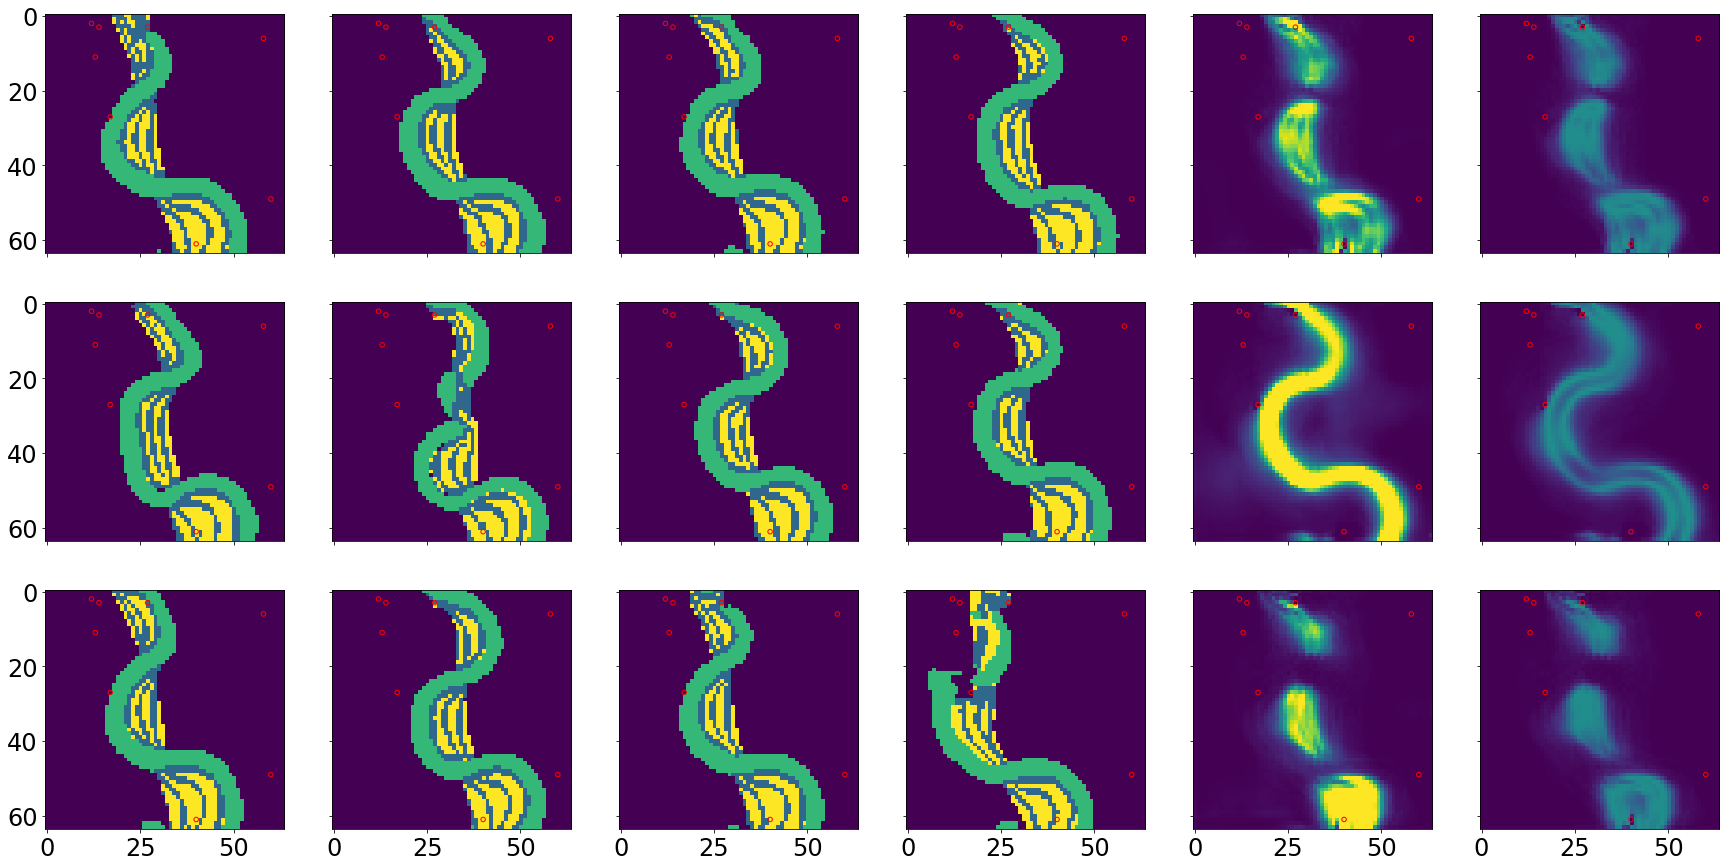

In [19]:
# Different realizations and mean and std

real_num = 1000
latents_plt = np.random.RandomState(410).randn(real_num, Gs.input_shapes[0][1], Gs.input_shapes[0][2], Gs.input_shapes[0][3])
labels_plt = np.tile(np.expand_dims(np.expand_dims(labels_test[test_num:test_num+1], axis = -1), axis = -1), (real_num, 1, 64, 64))  #
wellfacies_plt = np.repeat(wellfaciesimgs_test_G_illu, real_num, axis=0)
prob_plt = np.repeat(probimgs_test[test_num:test_num+1], real_num, axis=0)
 
fakemodel_indicators_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt, prob_plt)
fakemodels_plt = np.expand_dims(np.argmax(fakemodel_indicators_plt, axis = 1), axis = 1)

fakemodel_freq_md = np.average(fakemodel_indicators_plt[:, 1], axis = 0)
fakemodel_var_md = np.var(fakemodel_indicators_plt[:, 1], axis = 0)
fakemodel_freq_cf = np.average(fakemodel_indicators_plt[:, 2], axis = 0)
fakemodel_var_cf = np.var(fakemodel_indicators_plt[:, 2], axis = 0)
fakemodel_freq_la = np.average(fakemodel_indicators_plt[:, 3], axis = 0)
fakemodel_var_la = np.var(fakemodel_indicators_plt[:, 3], axis = 0)

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 6, sharex='col', sharey='row')
fig.set_size_inches(30, 15, forward=True)
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(fakemodels_plt[i*5+j+10, 0])
ax[0, 4].imshow(fakemodel_freq_md, vmin = 0, vmax = 0.5) 
ax[0, 5].imshow(fakemodel_var_md, vmin = 0, vmax = 0.5) 
ax[1, 4].imshow(fakemodel_freq_cf, vmin = 0, vmax = 0.5) 
ax[1, 5].imshow(fakemodel_var_cf, vmin = 0, vmax = 0.5) 
ax[2, 4].imshow(fakemodel_freq_la, vmin = 0, vmax = 0.5) 
ax[2, 5].imshow(fakemodel_var_la, vmin = 0, vmax = 0.5) 

index_x=np.argwhere(wellfaciesimgs_test_G_illu[0, 0]>0)[:, 1]
index_y=np.argwhere(wellfaciesimgs_test_G_illu[0, 0]>0)[:, 0]
for i in range(3):
    for j in range(6):
        ax[i, j].scatter(index_x, index_y, s=20, marker='o', facecolor='none', edgecolor='red')

#plt.savefig(GANSim_dir + "Case1_realizations.png", dpi=200) 

#### (3) Evaluate global features of the predicted facies models

In [20]:
# global features of the GANSim results

img_indc_fp_gansim = fakemodel_indicators_plt[:, 0:1]
img_indc_md_gansim = fakemodel_indicators_plt[:, 1:2]
img_indc_cf_gansim = fakemodel_indicators_plt[:, 2:3]
img_indc_sd_gansim = fakemodel_indicators_plt[:, 3:4]

pb_cf_ratio_gansim = (np.mean(img_indc_md_gansim, axis = (1, 2, 3)) + np.mean(img_indc_sd_gansim, axis = (1, 2, 3))) / np.mean(img_indc_cf_gansim, axis = (1, 2, 3))
print(pb_cf_ratio_gansim.shape)
fp_prop_gansim = np.mean(img_indc_fp_gansim, axis = (1, 2, 3))
print(fp_prop_gansim.shape)

(1000,)
(1000,)


In [21]:
# global features of the SNESIM results

snesim_fp_indc = np.where(mps_results == 0, 1, 0)
snesim_md_indc = np.where(mps_results == 1, 1, 0)
snesim_la_indc = np.where(mps_results == 3, 1, 0)
snesim_cf_indc = np.where(mps_results == 2, 1, 0)


fp_prop_snesim = np.mean(snesim_fp_indc, axis = (0, 1))
pb_cf_ratio_snesim = (np.mean(snesim_md_indc, axis = (0, 1)) + np.mean(snesim_la_indc, axis = (0, 1))) / np.mean(snesim_cf_indc, axis = (0, 1))

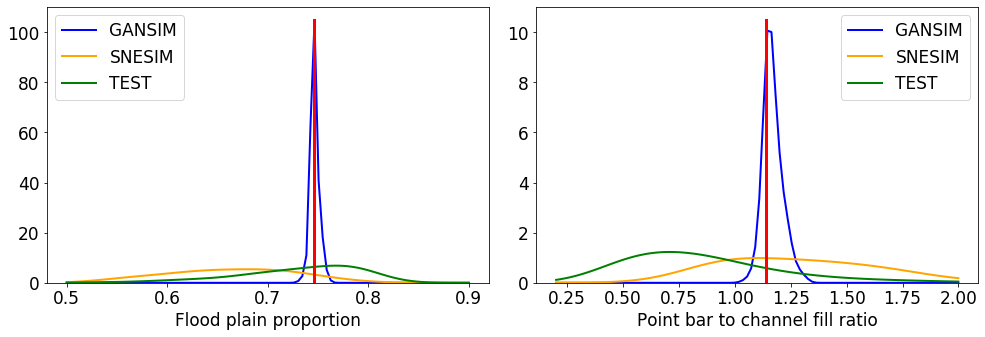

In [22]:
plt.rcParams.update({'font.size': 17})

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 5)

from scipy.stats import gaussian_kde
x_range = np.linspace(0.5, 0.9, 100)  # Generate range of values for x-axis
kde_cond_gansim = gaussian_kde(fp_prop_gansim, bw_method=0.4)
pdf_values_cond_gansim = kde_cond_gansim(x_range)  # Compute PDF values for the range
kde_snesim = gaussian_kde(fp_prop_snesim, bw_method=0.5)
pdf_values_snesim = kde_snesim(x_range)  # Compute PDF values for the range
kde = gaussian_kde(fp_prop, bw_method=0.4)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[0].plot(x_range, pdf_values_cond_gansim, 'blue', linewidth=2, label='GANSIM')  # Plot PDF for mudprop_cond_R
ax[0].plot(x_range, pdf_values_snesim, 'orange', linewidth=2, label='SNESIM')  # Plot PDF for mudprop_mcmc_R
ax[0].plot(x_range, pdf_values, 'g', linewidth=2, label='TEST')  # Plot PDF for mudprop
ax[0].plot([0.746, 0.746], [0, 105], 'r-', linewidth=3)  # Increase linewidth for a bolder appearance
ax[0].set_ylim(bottom=0)
ax[0].set_xlabel('Flood plain proportion')

from scipy.stats import gaussian_kde
x_range = np.linspace(0.2, 2., 100)  # Generate range of values for x-axis
kde_cond_gansim = gaussian_kde(pb_cf_ratio_gansim, bw_method=0.4)
pdf_values_cond_gansim = kde_cond_gansim(x_range)  # Compute PDF values for the range
kde_snesim = gaussian_kde(pb_cf_ratio_snesim, bw_method=0.5)
pdf_values_snesim = kde_snesim(x_range)  # Compute PDF values for the range

kde = gaussian_kde(pb_cf_ratio, bw_method=0.4)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[1].plot(x_range, pdf_values_cond_gansim, 'blue', linewidth=2, label='GANSIM')  # Plot PDF for mudprop_cond_R
ax[1].plot(x_range, pdf_values_snesim, 'orange', linewidth=2, label='SNESIM')  # Plot PDF for mudprop_mcmc_R
ax[1].plot(x_range, pdf_values, 'g', linewidth=2, label='TEST')  # Plot PDF for mudprop
ax[1].plot([1.14, 1.14], [0, 10.5], 'r-', linewidth=3)  # Increase linewidth for a bolder appearance
ax[1].set_ylim(bottom=0)
ax[1].set_xlabel('Point bar to channel fill ratio')

# Add legends to each subplot
ax[0].legend(loc='upper left')   # adjust position if it overlaps curves
ax[1].legend(loc='upper right')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.25)

# Use tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the figure
# plt.savefig(GANSim_dir + "GlobalFeature_histograms.jpg", dpi=100)



#### (4) Gradually changing input flood plain proportion value

In [27]:
# --- Varying Flood Plain Proportion to Generate Realizations ---

# Number of realizations to generate
real_num = 6

# Original test flood plain proportion (raw, before normalization)
fp_prop_raw = (labels_test[test_num, 1] / 2 + 0.5) * (0.82 - 0.5) + 0.5
# Generate 6 fp_prop values from -30% to +20% of the original test fp_prop
fp_prop_varied_raw = np.linspace(0.85 * fp_prop_raw, 1.2 * fp_prop_raw, real_num)
# Normalize fp_prop values into the range of [-1, 1]
fp_prop_varied_norm = ((fp_prop_varied_raw - 0.5) / (0.82 - 0.5) - 0.5) * 2

# Get the test features (normalized); shape of [6, 2]
labels_plt = np.tile(labels_test[test_num:test_num+1], (real_num, 1))
# Replace with the normalized gradually changing fp_prop values
labels_plt[:, 1] = fp_prop_varied_norm
# Expand to shape [real_num, 2, 64, 64]
labels_plt = labels_plt[:, :, np.newaxis, np.newaxis]
labels_plt = np.tile(labels_plt, (1, 1, 64, 64))

# Fixed latent cube (same for all realizations)
np.random.seed(81)
latents_plt = np.random.randn(8, 4, 4)
latents_plt = np.tile(latents_plt[np.newaxis, ...], (real_num, 1, 1, 1))  # shape: (6, 8, 4, 4)

# Repeat well facies and probability maps 6 times
wellfacies_plt = np.repeat(wellfaciesimgs_test_G_illu, real_num, axis=0)
prob_plt = np.repeat(probimgs_test[test_num:test_num+1], real_num, axis=0)

# Run generator
fakemodel_indicators_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt, prob_plt)
fakemodels_plt = np.expand_dims(np.argmax(fakemodel_indicators_plt, axis=1), axis=1)


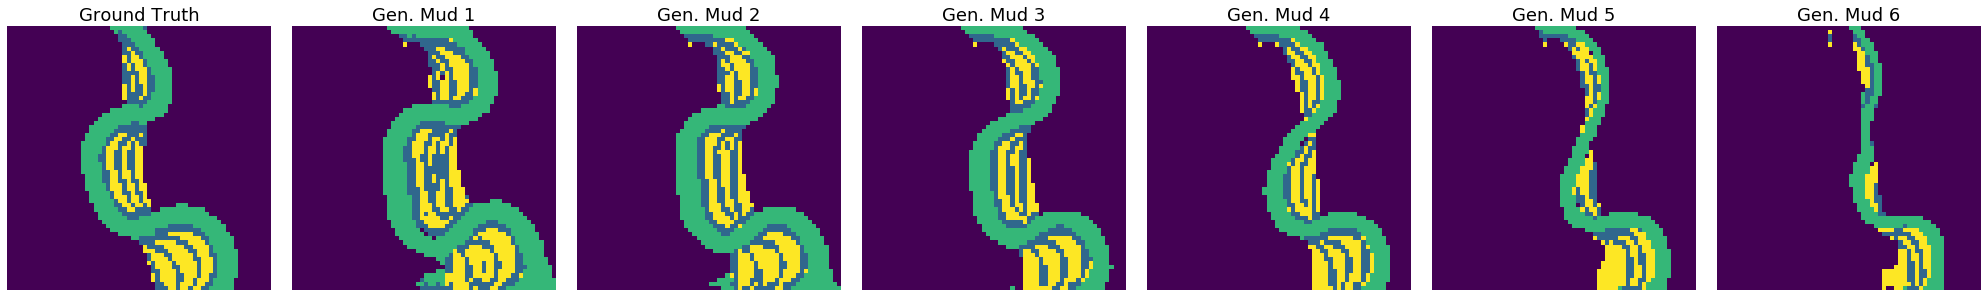

In [28]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 7, figsize=(28, 5))

# Plot ground truth facies map
axs[0].imshow(facies_test_newcode[test_num, 0])
axs[0].set_title("Ground Truth", fontsize=18)
axs[0].axis('off')

# Plot 6 generated facies maps
for i in range(6):
    axs[i + 1].imshow(fakemodels_plt[i, 0])
    axs[i + 1].set_title(f"Gen. Mud {i+1}", fontsize=18)
    axs[i + 1].axis('off')

plt.tight_layout()
plt.show()

### 5. Comparison of GANSim and SNESIM results based on flow simulation

*Flow simulation is conducted with Eclipse software, thus need to prepare permeability maps in appropriate format for Eclipse*

#### (1) Prepare permeability map files and boundary pressure values for flow simulation with Eclipse

*One ground truth facies model, 100 GANSim-simulated facies model, 100 SNESIM-simulated facies models*

In [23]:
# constructe permeablity maps based on facies maps

mps_results_transposed = mps_results.transpose(2, 0, 1)[:, np.newaxis, :, :]
perm = np.concatenate((facies_test_newcode[test_num:test_num + 1], fakemodels_plt[:100], mps_results_transposed))
perm = np.where(perm == 3, 2200, perm)
perm = np.where(perm == 2, 1500, perm)
perm = np.where(perm == 1, 50, perm)
perm = np.where(perm == 0, 10, perm)

In [24]:
def saveperm(dirpath, name, perm_map):
    text_name = dirpath + name
    perm_map = np.around(perm_map.reshape(-1))
    
    file = open(text_name, 'a')
    s = 'PERMI'+'\n' # Eclipse Keyword 
    file.write(s)
    for i in range(64*64//26):
        s = str(perm_map[i*26:(i+1)*26]).replace('[', ' ').replace(']', ' ')+'\n'
        file.write(s)    
    s = str(perm_map[-14:]).replace('[', ' ').replace(']', ' ')+'\n'    
    file.write(s)
    file.write('/')
    file.close()

In [25]:
# Write perm_maps into file which Eclipse can recognize and use for flow simulation
savedirpath = '/scratch/users/suihong/Mud_drape_Channels/TrainedModels/PointBar_Flow_case1/Perm_BoundaryPres/'

for i in range(perm.shape[0]):
    name = 'permmap_'+str(i+1)
    perm_map = perm[i]
    saveperm(savedirpath, name, perm_map)

In [26]:
small_pres_bound = np.zeros((perm.shape[0], 1)) + 250 # as the small pressure boundary and initial pressure map valaue
large_pres_dound = np.zeros((perm.shape[0], 1)) + 300 

press_bound_values = np.concatenate((large_pres_dound, small_pres_bound), axis=1)

press_name = '/scratch/users/suihong/Mud_drape_Channels/TrainedModels/PointBar_Flow_case1/Perm_BoundaryPres/PressureBoundaryValues.txt'
np.savetxt(press_name, press_bound_values, fmt="%1.8f ", newline='\n')   

#### (2) Conduct flow simulation with Eclipse

*See 3_4_Codes_for_Flow_Simulation_by_Calling_Eclipse.ipynb for codes of automatically calling Eclipse to do flow simulation for different permeability maps and boundary pressure values.*

#### (3) Import and visualize simulated pressure results from Eclipse

In [27]:
# Import pressure maps
pres_path = '/scratch/users/suihong/Mud_drape_Channels/TrainedModels/PointBar_Flow_case1/SimulatedPres/'

pressmaps=np.zeros((201, 30, 64, 64))
s = []
for i in range(1, 202):
    pres_name = pres_path + 'sim_pressuremaps_'+str(i)
    with open(pres_name, 'r') as f:
        for line in f:
            s.append(line.strip().split(' '))
pressmaps = np.array(s).reshape(-1,30,64,64).astype(np.float32)
    
print(pressmaps.shape)

(201, 30, 64, 64)


*Flow simulation results for ground truth facies model*

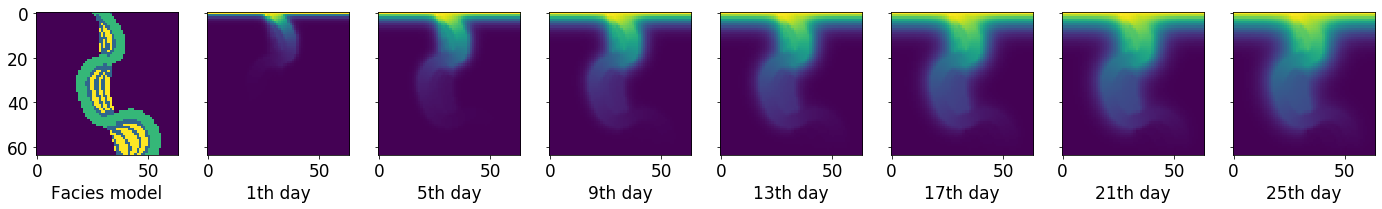

In [28]:
fig, ax = plt.subplots(1, 8, sharex='col', sharey='row')
fig.set_size_inches(24, 4, forward=True)
for i in range(7):
    ax[i + 1].imshow(pressmaps[0, i*4])
    
ax[0].imshow(facies_test_newcode[test_num,0,:,:])   

ax[0].set_xlabel('Facies model')           
for i in range(7):
    ax[i + 1].set_xlabel(str(i*4+1) + 'th day')   
# plt.savefig(GANSim_dir + "Case1_Pressmaps_Ref.jpg", dpi=100)

*Flow simulation results for GANSIM-generated facies model*

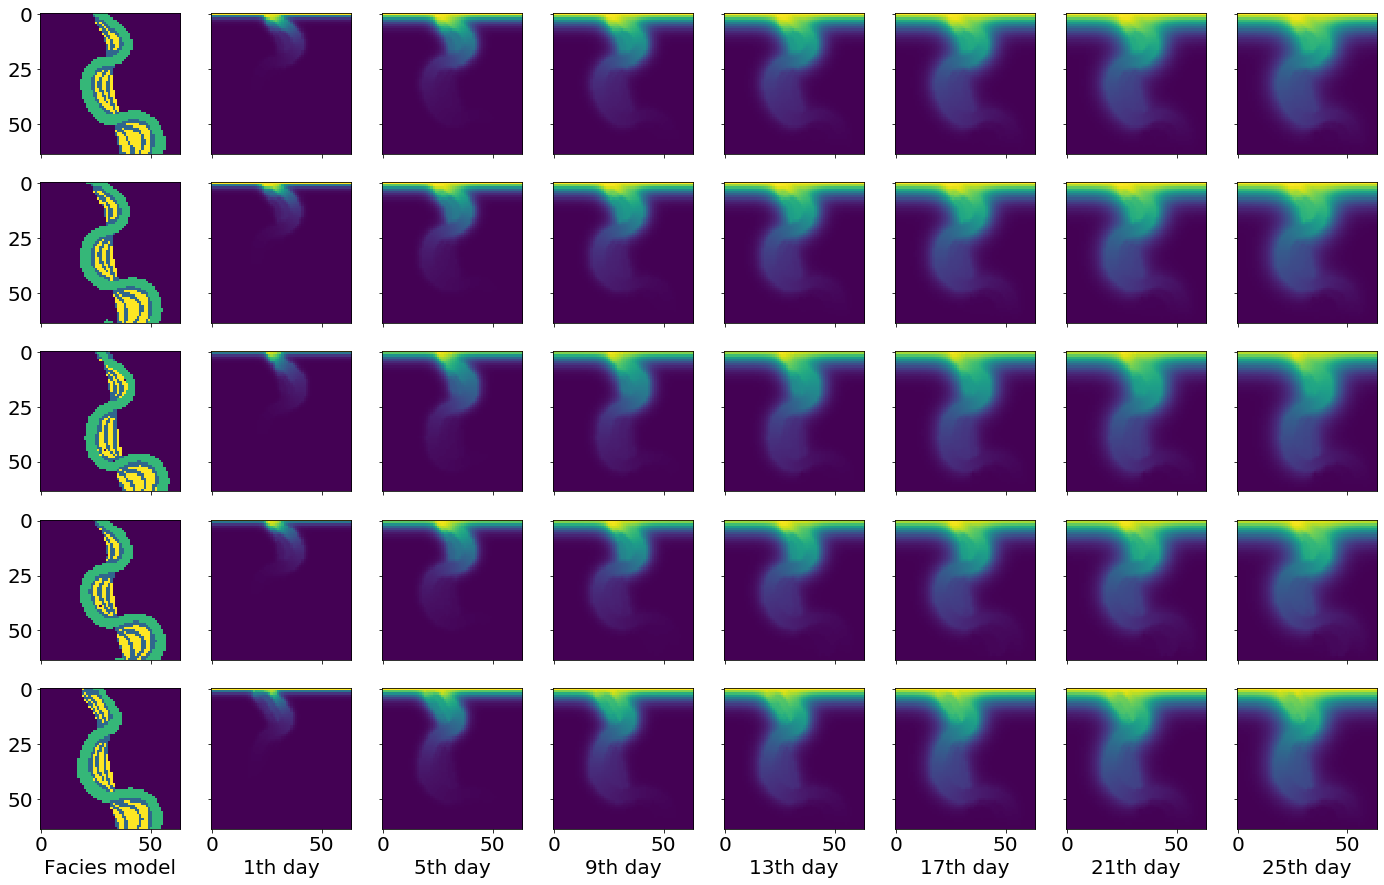

In [29]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(5, 8, sharex='col', sharey='row')
fig.set_size_inches(24, 15, forward=True)
for j in range(5):
    ax[j, 0].imshow(fakemodels_plt[35 + j, 0])
    
    for i in range(7):
        ax[j, i + 1].imshow(pressmaps[1 + 35 + j, i*4])

ax[4, 0].set_xlabel('Facies model')           
for i in range(7):
    ax[4, i + 1].set_xlabel(str(i*4+1) + 'th day')   

#plt.savefig(GANSim_dir + "Case1_Pressmaps_GANSim.jpg", dpi=100)

*Flow simulation results for SNESIM-generated facies model*

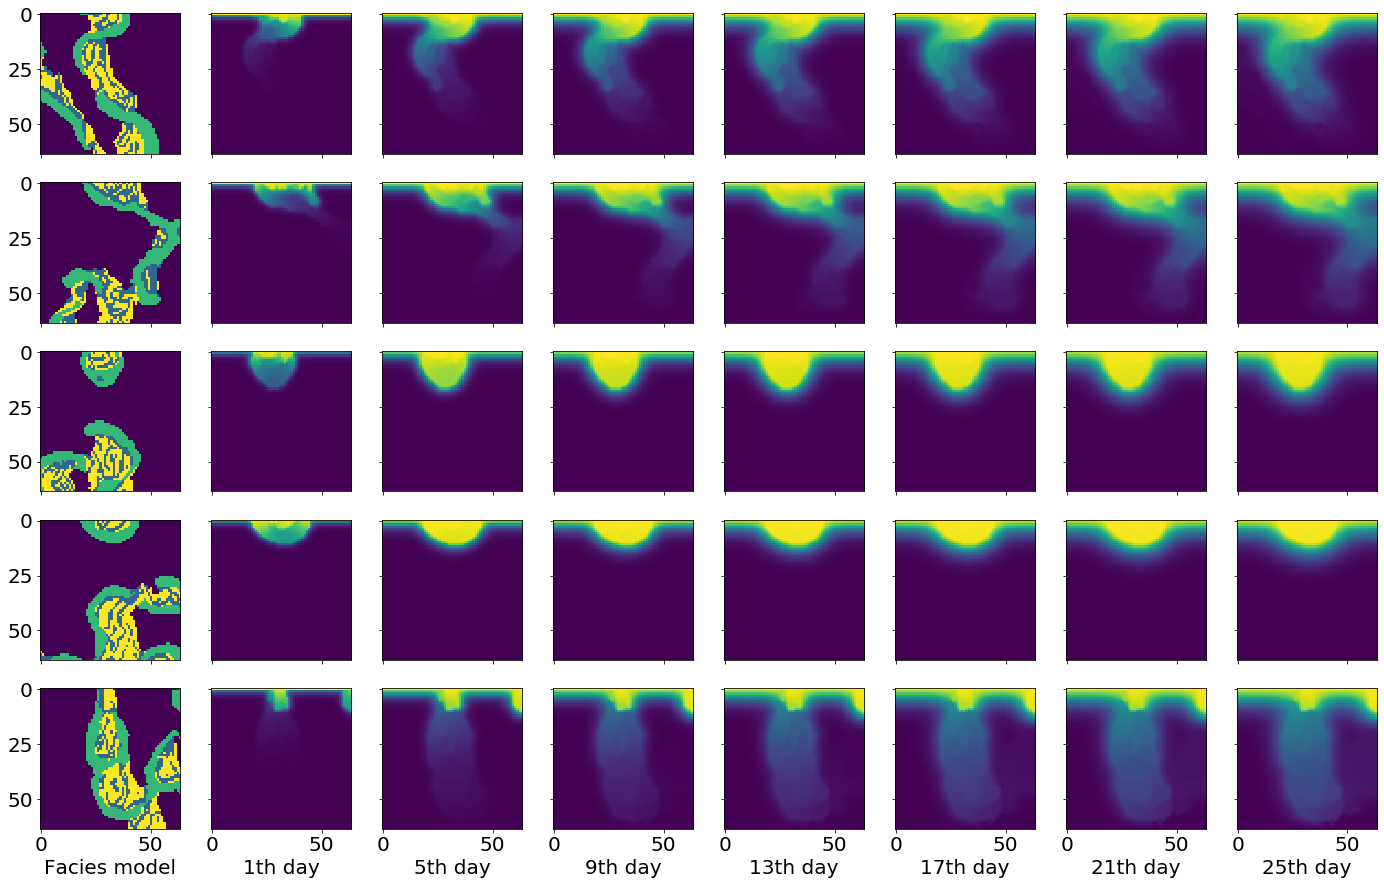

In [30]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(5, 8, sharex='col', sharey='row')
fig.set_size_inches(24, 15, forward=True)
for j in range(5):
    ax[j, 0].imshow(mps_results_transposed[j, 0])
    
    for i in range(7):
        ax[j, i + 1].imshow(pressmaps[101 + j, i*4])

ax[4, 0].set_xlabel('Facies model')           
for i in range(7):
    ax[4, i + 1].set_xlabel(str(i*4+1) + 'th day')   

# plt.savefig(GANSim_dir + "Case1_Pressmaps_SNESIM.jpg", dpi=100)

*Probability maps of being within the flow front, p(pressure>255 bar) on different days after flowing for GANSim and SNESIM*

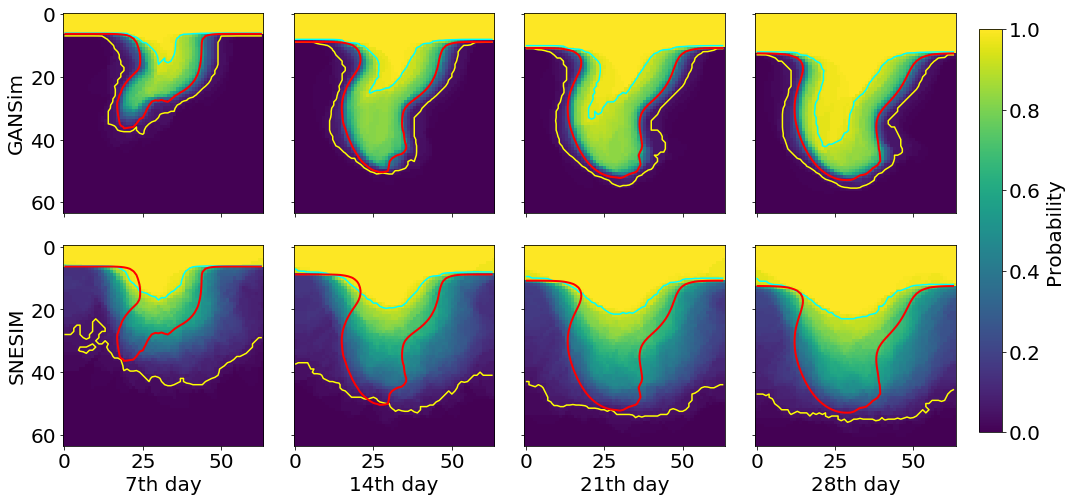

In [31]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

# Create figure and axes with black background
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row')
fig.set_size_inches(16, 8, forward=True)
fig.subplots_adjust(hspace=.15, wspace=.15)

pres_front_level = 255

# We will capture the first imshow object to link the colorbar to it
img = None

for i, day in enumerate([6, 13, 20, 27]):
    pressmaps_day_front = np.where(pressmaps[:, day] > pres_front_level, 1, 0)
    pressmaps_day_front_prob_gansim = np.mean(pressmaps_day_front[1:101], axis=0)
    pressmaps_day_front_prob_snesim = np.mean(pressmaps_day_front[101:201], axis=0)

    # GANSim subplot
    img = ax[0, i].imshow(pressmaps_day_front_prob_gansim, vmin=0, vmax=1, cmap='viridis')
    ax[0, i].contour(pressmaps_day_front_prob_gansim, levels=[0.05], colors='yellow', linewidths=1.5)
    ax[0, i].contour(pressmaps_day_front_prob_gansim, levels=[0.95], colors='cyan', linewidths=1.5)
    ax[0, i].contour(pressmaps[0, day], levels=[pres_front_level], colors='red', linewidths=2)

    # SNESIM subplot
    ax[1, i].imshow(pressmaps_day_front_prob_snesim, vmin=0, vmax=1, cmap='viridis')
    ax[1, i].contour(pressmaps_day_front_prob_snesim, levels=[0.05], colors='yellow', linewidths=1.5)
    ax[1, i].contour(pressmaps_day_front_prob_snesim, levels=[0.95], colors='cyan', linewidths=1.5)
    ax[1, i].contour(pressmaps[0, day], levels=[pres_front_level], colors='red', linewidths=2)

    ax[1, i].set_xlabel(str(day + 1) + 'th day')

# Set y-axis labels
ax[0, 0].set_ylabel('GANSim')
ax[1, 0].set_ylabel('SNESIM')

# Add a colorbar to the right of all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(img, cax=cbar_ax, label='Probability')

# Save the figure if needed
# plt.savefig(GANSim_dir + "Case1_FlowBoundary.png", dpi=100)

plt.show()


### 6. Application of the trained generator for geomodelling of large reservoirs

*Generation of facies maps of 192x192*

#### 6.1. Prepare conditioning dataset

*Load the large training image*

(192, 192)


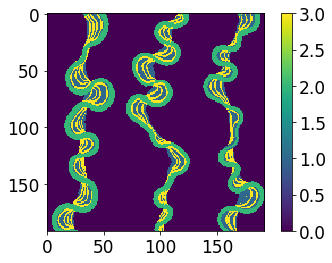

In [32]:
MPS_dir = '/scratch/users/suihong/Mud_drape_Channels/MPS/TI_large/'
resolution_x = 192
resolution_y = 192
TI_final_loaded = np.load(MPS_dir + "Unc_point_TI.npy")[:resolution_x, :resolution_y]

plt.rcParams.update({'font.size': 17})

print(TI_final_loaded.shape)
plt.imshow(TI_final_loaded)
plt.colorbar()

*Prepare conditioning well facies data from the loaded large training image*

In [70]:
geomodel_large_truth = TI_final_loaded[np.newaxis, np.newaxis, :, :]

# Generate random well points
geomodel_large_truth_wellpoints = np.zeros(geomodel_large_truth.shape, dtype = np.int8)
for i in range(1):
    well_points_num = 15 # total number of well points
    xs = np.random.RandomState(123*i+123).choice(geomodel_large_truth.shape[2], well_points_num)
    ys = np.random.RandomState(3*i + i*i+111).choice(geomodel_large_truth.shape[3], well_points_num)
    geomodel_large_truth_wellpoints[i, 0, xs, ys] = 1
    
geomodel_large_truth_wellfacies = geomodel_large_truth * geomodel_large_truth_wellpoints

geomodel_large_truth_wellfacies = np.concatenate((geomodel_large_truth_wellpoints, geomodel_large_truth_wellfacies), axis = 1)
geomodel_large_truth_wellfacies = geomodel_large_truth_wellfacies[:, :, :resolution_x, :resolution_y]

print(geomodel_large_truth_wellfacies.shape)


(1, 2, 192, 192)


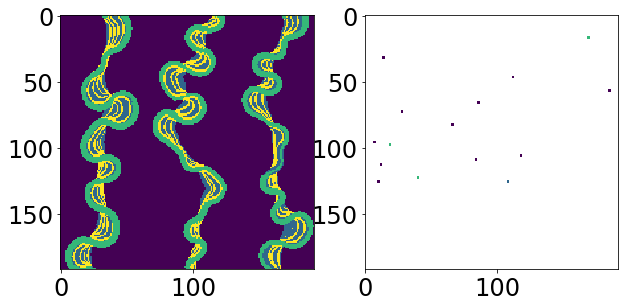

In [71]:
# Only for better visualization of the prepared well facies data


geomodel_large_truth_wellfacies_onechannel = enlarge(geomodel_large_truth_wellfacies[:, 0:1] + geomodel_large_truth_wellfacies[:, 1:2])
geomodel_large_truth_wellfacies_onechannel_mask = np.ma.masked_where(geomodel_large_truth_wellfacies_onechannel == 0, geomodel_large_truth_wellfacies_onechannel)

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5, forward=True)

ax[0].imshow(TI_final_loaded, cmap=cmap_well, vmin = 0, vmax = 3)
ax[1].imshow(geomodel_large_truth_wellfacies_onechannel_mask[0, 0].astype(np.float32), vmin = 1, vmax = 4)


*Prepare conditioning facies probability maps from the loaded large training image*

In [72]:
def noise(img, max_noise_size):
    img_x = img.shape[0]
    img_y = img.shape[1]
    img_noise = np.zeros(img.shape)
    # (1) add noise within the facies of indicator = 1 
    noise_num_max = np.round(np.sum(img)/40)
    if noise_num_max>0:       
        ind_indices = np.argwhere(img>=0.9)
        noise_num = np.random.RandomState(123).randint(0, noise_num_max)
        noise_indices = np.random.RandomState(123).randint(0, ind_indices.shape[0], noise_num)    
        noise_coos = ind_indices[noise_indices]
        noise_sizes = np.random.RandomState(123).randint(3, max_noise_size, noise_num)  
        noise_values = np.random.RandomState(123).uniform(-2., 1.5, noise_num)
        for i in range(noise_num):
            noise_coo_i_x = noise_coos[i, 0]
            noise_coo_i_y = noise_coos[i, 1]
            noise_size_i = noise_sizes[i]
            noise_value_i = noise_values[i]
            img_noise[noise_coo_i_x:min(img_x, noise_coo_i_x + noise_size_i), noise_coo_i_y:min(img_y, noise_coo_i_y + noise_size_i)]=noise_value_i
   
    # (2) add noise within the facies of indicator = 0
    noise_num_max = np.round((img_x*img_y - np.sum(img))/40)
    if noise_num_max>0:
        ind_indices = np.argwhere(img<=0.1)
        noise_num = np.random.RandomState(123).randint(0, noise_num_max)
        noise_indices = np.random.RandomState(123).randint(0, ind_indices.shape[0], noise_num)    
        noise_coos = ind_indices[noise_indices]
        noise_sizes = np.random.RandomState(123).randint(3, max_noise_size, noise_num)  
        noise_values = np.random.RandomState(123).uniform(0., 1., noise_num)
        for i in range(noise_num):
            noise_coo_i_x = noise_coos[i, 0]
            noise_coo_i_y = noise_coos[i, 1]
            noise_size_i = noise_sizes[i]
            noise_value_i = noise_values[i]
            img_noise[noise_coo_i_x:min(img_x, noise_coo_i_x + noise_size_i), noise_coo_i_y:min(img_y, noise_coo_i_y + noise_size_i)]=noise_value_i
    return img_noise

# Using Gaussian kernels with various size to smooth the indicator of underground-river-related cave facies to form the probability maps of caves with various blurriness. 
from scipy import ndimage

geomodel_large_truth_prob = np.zeros((geomodel_large_truth.shape[0], 3, geomodel_large_truth.shape[2], geomodel_large_truth.shape[3]), dtype=np.float16) 
for num in range(geomodel_large_truth_prob.shape[0]):  
    if num % 100 == 0:
        print(num)  
    k = np.random.RandomState(123).choice([3., 4., 5.])
    
    geomodel_large_truth_indc_md = np.where(geomodel_large_truth == 1, 1, 0)
    geomodel_large_truth_indc_cf = np.where(geomodel_large_truth == 2, 1, 0)
    geomodel_large_truth_indc_sd = np.where(geomodel_large_truth == 3, 1, 0)
    
    cur_indc_md = geomodel_large_truth_indc_md[num, 0].astype(np.float32)
    cur_indc_fc = geomodel_large_truth_indc_cf[num, 0].astype(np.float32)
    cur_indc_sd = geomodel_large_truth_indc_sd[num, 0].astype(np.float32)
    cur_indc_md_noise = noise(cur_indc_md, 6)
    cur_indc_fc_noise = noise(cur_indc_fc, 9) 
    cur_indc_sd_noise = noise(cur_indc_sd, 6)
    cur_noise_prob_md = ndimage.gaussian_filter(cur_indc_md_noise, sigma = (k, k), mode = 'reflect')
    cur_noise_prob_fc = ndimage.gaussian_filter(cur_indc_fc_noise, sigma = (k, k), mode = 'reflect') 
    cur_noise_prob_sd = ndimage.gaussian_filter(cur_indc_sd_noise, sigma = (k, k), mode = 'reflect') 
    prob_md_without_noise = ndimage.gaussian_filter(cur_indc_md, sigma = (k, k), mode = 'reflect') 
    prob_fc_without_noise = ndimage.gaussian_filter(cur_indc_fc, (k, k), mode = 'reflect') 
    prob_sd_without_noise = ndimage.gaussian_filter(cur_indc_sd, (k, k), mode = 'reflect')
    prob_md = prob_md_without_noise + cur_noise_prob_md
    prob_fc = prob_fc_without_noise + cur_noise_prob_fc 
    prob_sd = prob_sd_without_noise + cur_noise_prob_sd 

    prob_sum = prob_md + prob_fc + prob_sd  
    prob_sum_max = np.amax(prob_sum, axis = (0,1))
    if prob_sum_max<0.25:  # amplify the prob range beyond (0-0.25)
        prob_mx = np.random.RandomState(123).rand(1)*0.45+0.25
        prob_md = prob_md * prob_mx / prob_sum_max   
        prob_fc = prob_fc * prob_mx / prob_sum_max 
        prob_sd = prob_sd * prob_mx / prob_sum_max 
    
    if prob_sum_max>0.9: 
        prob_md = prob_md / prob_sum_max * 0.9
        prob_fc = prob_fc / prob_sum_max * 0.9
        prob_sd = prob_sd / prob_sum_max * 0.9
    
    geomodel_large_truth_prob[num, 0] = prob_md 
    geomodel_large_truth_prob[num, 1] = prob_fc
    geomodel_large_truth_prob[num, 2] = prob_sd
    
    geomodel_large_truth_prob[num] = np.where(geomodel_large_truth_prob[num]<0.02, 0.02, geomodel_large_truth_prob[num]) 
    
geomodel_large_truth_prob = geomodel_large_truth_prob[:, :, :resolution_x, :resolution_y]
print(geomodel_large_truth_prob.shape)

0
(1, 3, 192, 192)


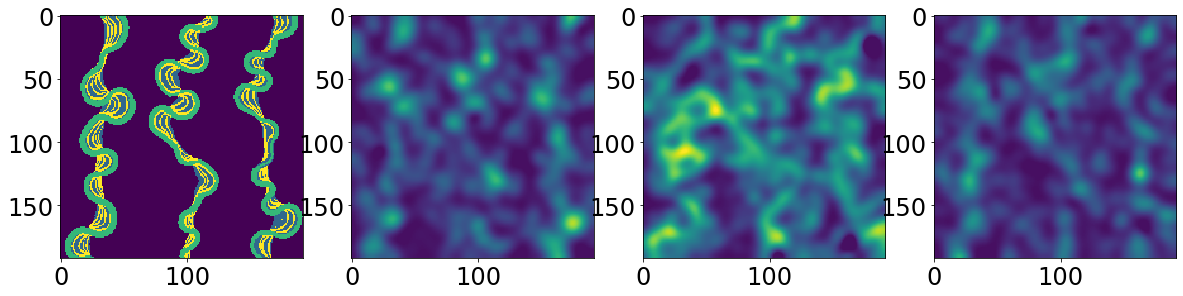

In [73]:
# Visualize probability maps
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(20, 5, forward=True)

ax[0].imshow(TI_final_loaded, cmap=cmap_well, vmin = 0, vmax = 3)
ax[1].imshow(geomodel_large_truth_prob[0, 0].astype(np.float32), vmin = 0, vmax = 0.5)
ax[2].imshow(geomodel_large_truth_prob[0, 1].astype(np.float32), vmin = 0, vmax = 0.5)
ax[3].imshow(geomodel_large_truth_prob[0, 2].astype(np.float32), vmin = 0, vmax = 0.5)

*Prepare conditioning global features from the loaded large training image*

In [74]:
TI_fp_prop = np.mean(np.where(TI_final_loaded==0, 1, 0))
TI_pb_to_cf_ratio = np.mean(np.where(((TI_final_loaded==1) | (TI_final_loaded==3)), 1, 0)) / np.mean(np.where(TI_final_loaded==2, 1, 0))

print(TI_fp_prop)
print(TI_pb_to_cf_ratio)

# Normalize into range of [-1, 1]
TI_pb_to_cf_ratio_norm = ((TI_pb_to_cf_ratio - 0.2) / (2 - 0.2) - 0.5) * 2
TI_fp_prop_norm = ((TI_fp_prop - 0.5) / (0.82 - 0.5) - 0.5) * 2
TI_label_norm = np.array([TI_pb_to_cf_ratio_norm, TI_fp_prop_norm])[np.newaxis, :, np.newaxis, np.newaxis]
print(TI_label_norm.shape)

0.7256130642361112
1.164099272571673
(1, 2, 1, 1)


#### 6.2. Randomly generate large facies models using GANSim conditioned on these data

*Generation of facies maps of 192x192*

In [75]:
tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
#tf.disable_eager_execution()

import config_large
import tfutil

resolution_x = 192
resolution_y = 192

latent_size_x = int(resolution_x/16)  # 16 is because the original generator enlarges input latent vector size from 4 into output facies model of 64
latent_size_y = int(resolution_y/16)  

Gs_enlarged = tfutil.Network('Gs_enlarged1', 
                             resolution_x = resolution_x, resolution_y = resolution_y,
                             latent_size_x = latent_size_x, latent_size_y = latent_size_y,    
                             **config_large.G) 

Gs_enlarged.copy_trainables_from(Gs)
print(Gs_enlarged.input_shapes)
#print(Gs_enlarged.print_layers())

[[Dimension(None), Dimension(8), Dimension(12), Dimension(12)], [Dimension(None), Dimension(2), Dimension(192), Dimension(192)], [Dimension(None), Dimension(2), Dimension(192), Dimension(192)], [Dimension(None), Dimension(3), Dimension(192), Dimension(192)]]


*Generate facies models (Stationary global features)*

In [76]:
real_num = 100
latents_plt = np.random.RandomState(160).randn(real_num, Gs_enlarged.input_shapes[0][1], Gs_enlarged.input_shapes[0][2], Gs_enlarged.input_shapes[0][3])
labels_plt = np.tile(TI_label_norm, (real_num, 1, resolution_x, resolution_y))  #

wellfacies_plt = np.repeat(geomodel_large_truth_wellfacies, real_num, axis=0)
wellfacies_plt[:, 1] = np.where(wellfacies_plt[:, 1] > 1, wellfacies_plt[:, 1] + 1, wellfacies_plt[:, 1]) # change facies codes from 0, 1, 2, 3 into 0, 1, 3, 4.

prob_plt = np.repeat(geomodel_large_truth_prob, real_num, axis=0)
 
fakemodel_indicators_plt = Gs_enlarged.run(latents_plt, labels_plt, wellfacies_plt, prob_plt)
fakemodels_plt = np.expand_dims(np.argmax(fakemodel_indicators_plt, axis = 1), axis = 1)
    
fakemodel_freq_md = np.average(fakemodel_indicators_plt[:, 1], axis = 0)
fakemodel_var_md = np.var(fakemodel_indicators_plt[:, 1], axis = 0)
fakemodel_freq_cf = np.average(fakemodel_indicators_plt[:, 2], axis = 0)
fakemodel_var_cf = np.var(fakemodel_indicators_plt[:, 2], axis = 0)
fakemodel_freq_la = np.average(fakemodel_indicators_plt[:, 3], axis = 0)
fakemodel_var_la = np.var(fakemodel_indicators_plt[:, 3], axis = 0)


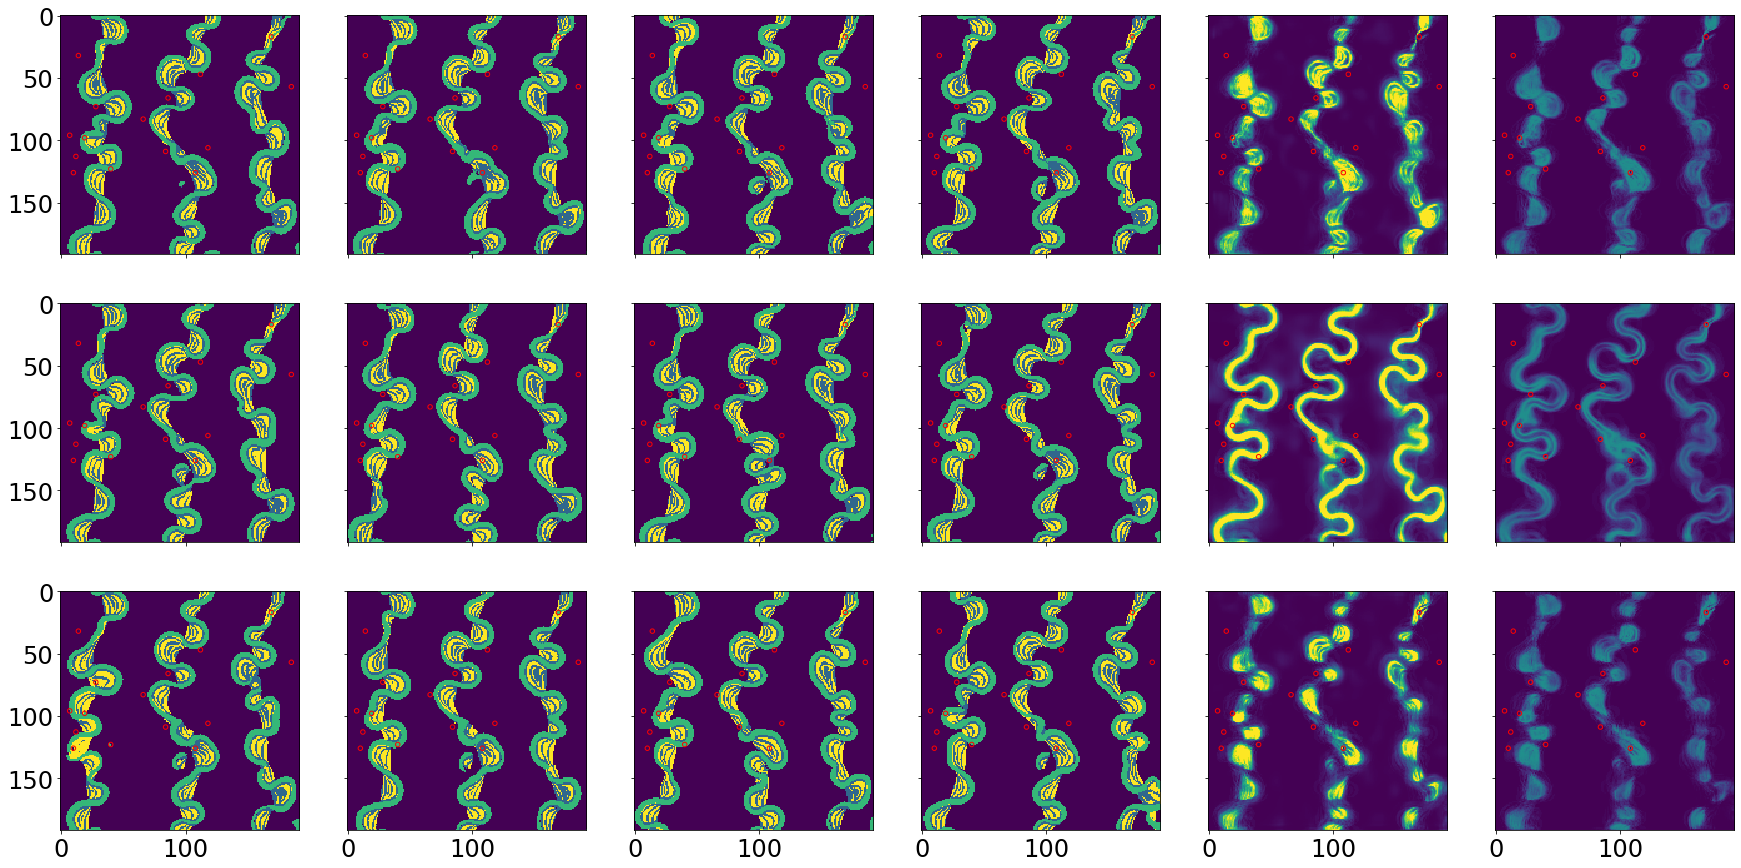

In [77]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 6, sharex='col', sharey='row')
fig.set_size_inches(30, 15, forward=True)
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(fakemodels_plt[i*5+j+10, 0])
ax[0, 4].imshow(fakemodel_freq_md, vmin = 0, vmax = 0.5) 
ax[0, 5].imshow(fakemodel_var_md, vmin = 0, vmax = 0.5) 
ax[1, 4].imshow(fakemodel_freq_cf, vmin = 0, vmax = 0.5) 
ax[1, 5].imshow(fakemodel_var_cf, vmin = 0, vmax = 0.5) 
ax[2, 4].imshow(fakemodel_freq_la, vmin = 0, vmax = 0.5) 
ax[2, 5].imshow(fakemodel_var_la, vmin = 0, vmax = 0.5) 

#ax[0, 0].imshow(TI_final_loaded) 

index_x=np.argwhere(geomodel_large_truth_wellfacies[0, 0] >0)[:, 1]
index_y=np.argwhere(geomodel_large_truth_wellfacies[0, 0] >0)[:, 0]
for i in range(3):
    for j in range(6):
        ax[i, j].scatter(index_x, index_y, s=20, marker='o', facecolor='none', edgecolor='red')

*Generate facies models (Non-stationary global features)*

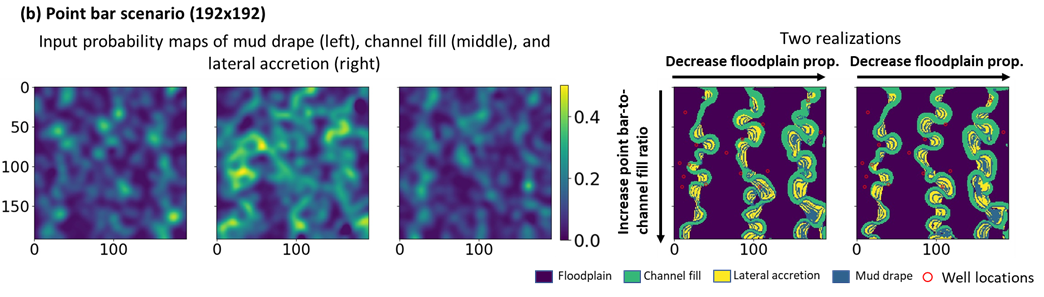

In [78]:
real_num = 100
latents_plt = np.random.RandomState(410).randn(real_num, Gs_enlarged.input_shapes[0][1], Gs_enlarged.input_shapes[0][2], Gs_enlarged.input_shapes[0][3])
labels_plt = np.tile(TI_label_norm, (real_num, 1, resolution_x, resolution_y))  #

labels_plt[:, 0] = np.expand_dims(np.tile(np.linspace(-1, 1, 192)[:, np.newaxis], (1, 192)), axis = 0)  # pb_to_cf_ratio
labels_plt[:, 1] = np.expand_dims(np.tile(np.linspace(1, -1, 192)[np.newaxis, :], (192, 1)), axis = 0)  # fp_prop

wellfacies_plt = np.repeat(geomodel_large_truth_wellfacies, real_num, axis=0)
wellfacies_plt[:, 1] = np.where(wellfacies_plt[:, 1] > 1, wellfacies_plt[:, 1] + 1, wellfacies_plt[:, 1]) # change facies codes from 0, 1, 2, 3 into 0, 1, 3, 4.
prob_plt = np.repeat(geomodel_large_truth_prob, real_num, axis=0)
 
fakemodel_indicators_plt = Gs_enlarged.run(latents_plt, labels_plt, wellfacies_plt, prob_plt)
fakemodels_plt = np.expand_dims(np.argmax(fakemodel_indicators_plt, axis = 1), axis = 1)
    
fakemodel_freq_md = np.average(fakemodel_indicators_plt[:, 1], axis = 0)
fakemodel_var_md = np.var(fakemodel_indicators_plt[:, 1], axis = 0)
fakemodel_freq_cf = np.average(fakemodel_indicators_plt[:, 2], axis = 0)
fakemodel_var_cf = np.var(fakemodel_indicators_plt[:, 2], axis = 0)
fakemodel_freq_la = np.average(fakemodel_indicators_plt[:, 3], axis = 0)
fakemodel_var_la = np.var(fakemodel_indicators_plt[:, 3], axis = 0)


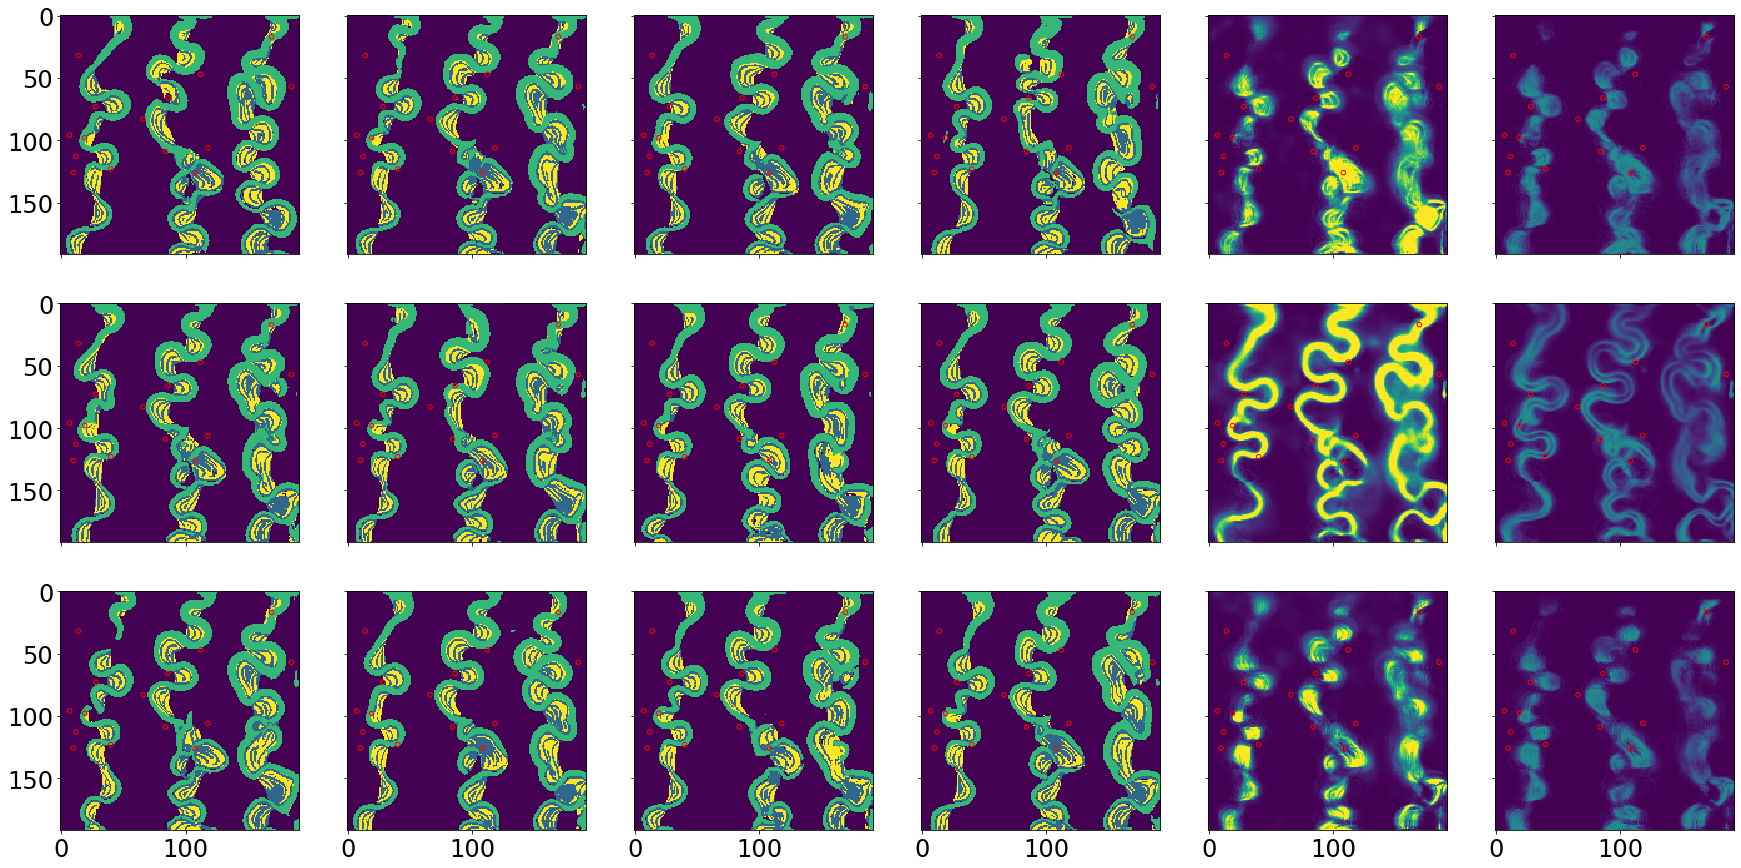

In [79]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 6, sharex='col', sharey='row')
fig.set_size_inches(30, 15, forward=True)
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(fakemodels_plt[i*5+j+10, 0])
ax[0, 4].imshow(fakemodel_freq_md, vmin = 0, vmax = 0.5) 
ax[0, 5].imshow(fakemodel_var_md, vmin = 0, vmax = 0.5) 
ax[1, 4].imshow(fakemodel_freq_cf, vmin = 0, vmax = 0.5) 
ax[1, 5].imshow(fakemodel_var_cf, vmin = 0, vmax = 0.5) 
ax[2, 4].imshow(fakemodel_freq_la, vmin = 0, vmax = 0.5) 
ax[2, 5].imshow(fakemodel_var_la, vmin = 0, vmax = 0.5) 

#ax[0, 0].imshow(TI_final_loaded) 

index_x=np.argwhere(geomodel_large_truth_wellfacies[0, 0] >0)[:, 1]
index_y=np.argwhere(geomodel_large_truth_wellfacies[0, 0] >0)[:, 0]
for i in range(3):
    for j in range(6):
        ax[i, j].scatter(index_x, index_y, s=20, marker='o', facecolor='none', edgecolor='red')

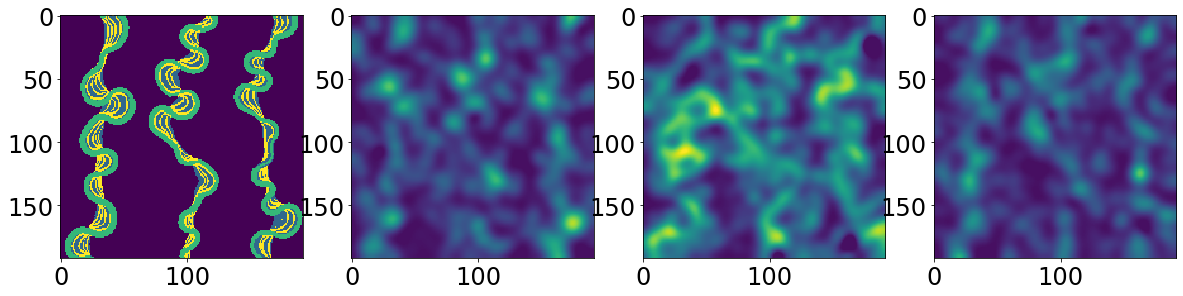

In [80]:
# Well facies data and probability maps
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(20, 5, forward=True)

ax[0].imshow(TI_final_loaded, cmap=cmap_well, vmin = 0, vmax = 3)
ax[1].imshow(geomodel_large_truth_prob[0, 0].astype(np.float32), vmin = 0, vmax = 0.5)
ax[2].imshow(geomodel_large_truth_prob[0, 1].astype(np.float32), vmin = 0, vmax = 0.5)
ax[3].imshow(geomodel_large_truth_prob[0, 2].astype(np.float32), vmin = 0, vmax = 0.5)

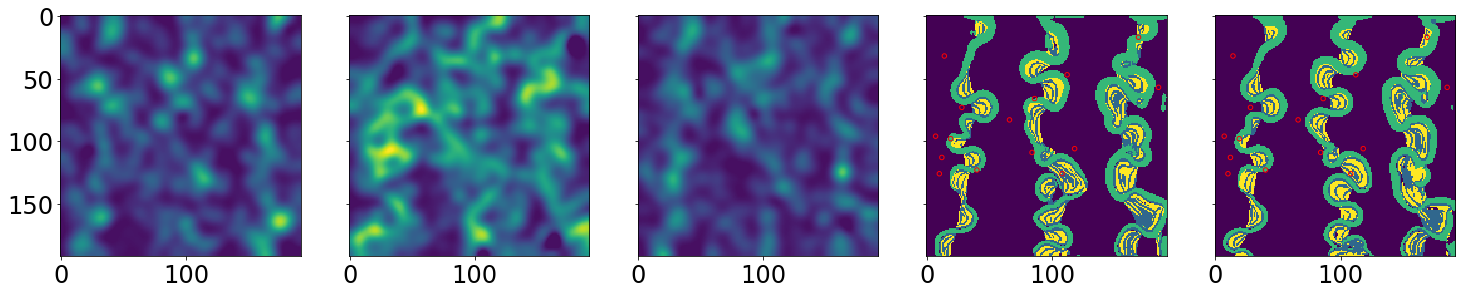

In [81]:
fig, ax = plt.subplots(1, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 5, forward=True)

ax[0].imshow(geomodel_large_truth_prob[0, 0].astype(np.float32), vmin = 0, vmax = 0.5)
ax[1].imshow(geomodel_large_truth_prob[0, 1].astype(np.float32), vmin = 0, vmax = 0.5)
ax[2].imshow(geomodel_large_truth_prob[0, 2].astype(np.float32), vmin = 0, vmax = 0.5)
ax[3].imshow(fakemodels_plt[16, 0])
ax[4].imshow(fakemodels_plt[17, 0])

index_x=np.argwhere(geomodel_large_truth_wellfacies[0, 0] >0)[:, 1]
index_y=np.argwhere(geomodel_large_truth_wellfacies[0, 0] >0)[:, 0]
for i in range(3, 5):
    ax[i].scatter(index_x, index_y, s=20, marker='o', facecolor='none', edgecolor='red')

# Save the figure
# plt.savefig(GANSim_dir + "LargeCase_conditional_realizations.jpg", dpi=100)


*Well facies reproduction accuracy*

In [82]:
wellfacies_plt_newcode = np.where(wellfacies_plt[:, 1:2] >2, wellfacies_plt[:, 1:2] - 1, wellfacies_plt[:, 1:2])
recognized = np.where(wellfacies_plt_newcode==fakemodels_plt, 1, 0) * wellfacies_plt[:, 0:1]
acc = np.sum(recognized)/np.sum(wellfacies_plt[:, 0:1])

print(acc)

1.0
